In [52]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

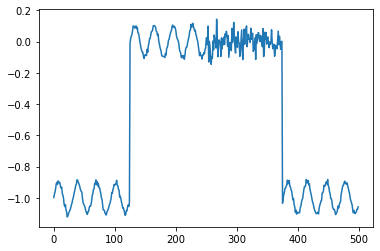

In [53]:
sampling_rate = 500
noise_amp = 0.01
vibrato_amp = 0.1


signal = np.sin(np.linspace(0, 100, sampling_rate))*vibrato_amp + np.random.randn(sampling_rate)*noise_amp

signal[:sampling_rate//4]-=1
signal[sampling_rate//2:3*sampling_rate//4] = np.random.randn(sampling_rate//4)*noise_amp*5 # noisy
signal[3*sampling_rate//4:sampling_rate] -= 1

plt.plot(signal)
plt.show()

In [54]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [55]:
def sliding_windows(data, seq_length): # label like
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


sc = MinMaxScaler()
training_data = sc.fit_transform(signal.reshape(-1, 1))
training_data = signal.reshape(-1, 1) 

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.660)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [56]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.29755
Epoch: 100, loss: 0.00913
Epoch: 200, loss: 0.00819
Epoch: 300, loss: 0.00748
Epoch: 400, loss: 0.00674
Epoch: 500, loss: 0.00600
Epoch: 600, loss: 0.00539
Epoch: 700, loss: 0.00498
Epoch: 800, loss: 0.00475
Epoch: 900, loss: 0.00463
Epoch: 1000, loss: 0.00458
Epoch: 1100, loss: 0.00455
Epoch: 1200, loss: 0.00454
Epoch: 1300, loss: 0.00453
Epoch: 1400, loss: 0.00452
Epoch: 1500, loss: 0.00451
Epoch: 1600, loss: 0.00450
Epoch: 1700, loss: 0.00450
Epoch: 1800, loss: 0.00449
Epoch: 1900, loss: 0.00449


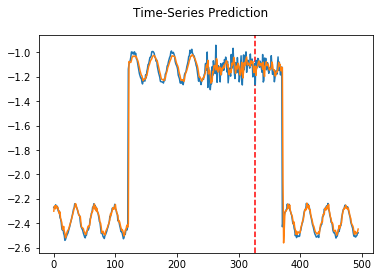

In [57]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

# Bi-directional GRU (same task)

In [58]:
bi_grus = torch.nn.GRU(input_size=1, hidden_size=1, num_layers=1, batch_first=False, bidirectional=True)

# unidirectional gru for feeding the model : 
reverse_gru = torch.nn.GRU(input_size=1, hidden_size=1, num_layers=1, batch_first=False, bidirectional=False)

#adjusting the weights : 


reverse_gru.weight_ih_l0 = bi_grus.weight_ih_l0_reverse
reverse_gru.weight_hh_l0 = bi_grus.weight_hh_l0_reverse
reverse_gru.bias_ih_l0 = bi_grus.bias_ih_l0_reverse
reverse_gru.bias_hh_l0 = bi_grus.bias_hh_l0_reverse





In [59]:
bi_output, bi_hidden = bi_grus(dataX)
reverse_output, reverse_hidden = reverse_gru(trainX[np.arange(4, -1, -1), :, :])


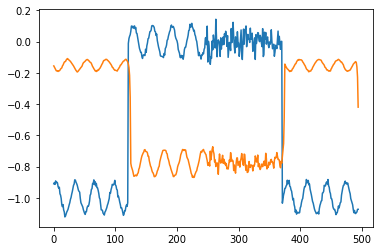

In [60]:
predict = bi_output[:, 0, 1].detach().numpy()
predict = sc.inverse_transform(bi_output[:, 0, 1].detach().numpy().reshape(-1, 1))

plt.plot(dataY)
plt.plot(predict)
plt.show()